# Performance Analysis of Model

This notebook will guide through my performance analysis of the model.

We'll target a few questions:
- How well does the model perform?
- What assumptions are made?
- What does the model perform better on? What about the poor ones?

## Preparation

As usual, we'll load relevant libraries and ...
- Load our test data
- Load our model

In [14]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl

from opal import OpalNet
from opal.datamodule import ScoreDataModule

dm = ScoreDataModule(
    osu_files_path=Path(r"D:\osu!db\2023_05_01_osu_files\2023_05_01_osu_files\\"),
    batch_size=64,
    accuracy_bounds=(0.85, 1),
)

In [15]:
net = OpalNet.load_from_checkpoint("model.ckpt")

In [16]:
net

OpalNet(
  (model): OpalNetModule(
    (u_mf_emb): Embedding(32238, 8)
    (m_mf_emb): Embedding(12875, 8)
    (mf_net): Sequential(
      (0): OpalNetBlock(
        (net): Sequential(
          (0): Linear(in_features=8, out_features=8, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): OpalNetBlock(
        (net): Sequential(
          (0): Linear(in_features=8, out_features=8, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (u_mlp_emb): Embedding(32238, 8)
    (m_mlp_emb): Embedding(12875, 8)
    (mlp_net): Sequential(
      (0): OpalNetBlock(
        (net): Sequential(
          (0): Linear(in_features=16, out_features=128, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): OpalNetBlock(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=64, bias=True)
          (1): ReLU()
          (2)

In [17]:
trainer = pl.Trainer(accelerator='gpu', limit_predict_batches=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Predicting
We'll use our validation data to predict.

In [18]:
y = trainer.predict(net, dataloaders=dm.test_dataloader())

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was 

In [19]:
y_preds = []
y_trues = []
x_uid_reals = []
x_mid_reals = []
for x_uid_real, x_mid_real, y_pred, y_true in y:
    x_uid_reals.append(x_uid_real)
    x_mid_reals.append(x_mid_real)
    y_preds.append(y_pred)
    y_trues.append(y_true)
y_preds = np.concatenate(y_preds).flatten()
y_trues = np.concatenate(y_trues).flatten()
x_uid_reals = np.concatenate(x_uid_reals).flatten()
x_mid_reals = np.concatenate(x_mid_reals).flatten()

In [20]:
df = pd.DataFrame(
    data=dict(
        y_preds=y_preds,
        y_trues=y_trues,
        x_uid_reals=x_uid_reals,
        x_mid_reals=x_mid_reals,
    )
)

In [21]:
df['error'] = np.abs(df.y_preds - df.y_trues)
df =  df.sort_values('error')

# Analysis

We'll firstly do some quick viz to get an intuition of the data

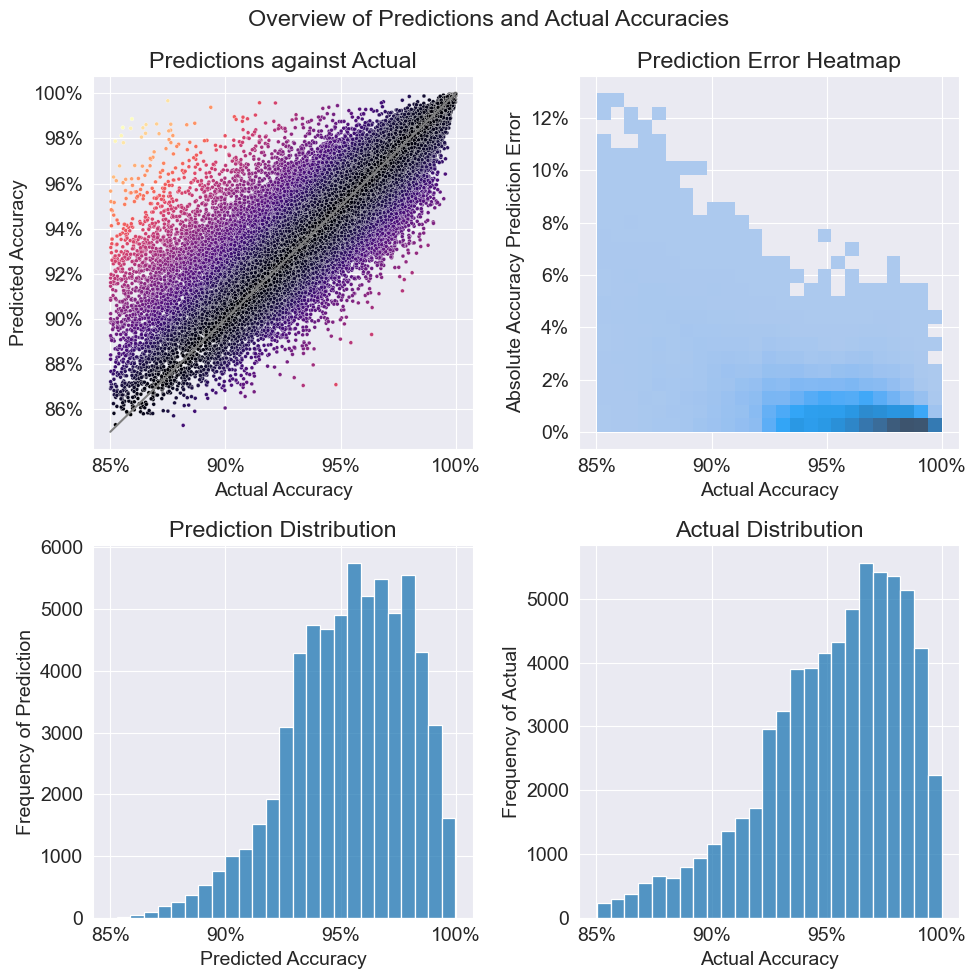

In [22]:
import seaborn as sns
import matplotlib.ticker as mtick

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 10))
plt.suptitle("Overview of Predictions and Actual Accuracies")

ax1 = plt.subplot(221)
sns.lineplot(x=[0.85, 1], y=[0.85, 1], color='gray')
sns.scatterplot(x=y_trues, y=y_preds, s=8, c=np.abs(y_trues - y_preds),
                cmap='magma')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Predictions against Actual")
plt.xlabel("Actual Accuracy")
plt.ylabel("Predicted Accuracy")

ax2 = plt.subplot(222)
ax2.sharex(ax1)
sns.histplot(x=y_trues, y=np.abs(y_preds - y_trues), bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Prediction Error Heatmap")
plt.xlabel("Actual Accuracy")
plt.ylabel("Absolute Accuracy Prediction Error")

ax3 = plt.subplot(223)
ax3.sharex(ax1)
sns.histplot(x=y_preds, bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Prediction Distribution")
plt.xlabel("Predicted Accuracy")
plt.ylabel("Frequency of Prediction")

ax4 = plt.subplot(224)
ax4.sharex(ax1)
sns.histplot(x=y_trues, bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Actual Distribution")
plt.xlabel("Actual Accuracy")
plt.ylabel("Frequency of Actual")
plt.tight_layout()
plt.savefig("overview.png")
plt.show()

## Analysis of input

We also have our `DataFrame` of input data, let's take a glance

In [23]:
df = dm.df

In [24]:
df.head()

,sid,mid,uid,accuracy,uid_le,mid_le
0,78599748,193128/0,3155787/2014,1.470702,22077,3358
1,81140543,193128/0,1923091/2014,-0.054382,13991,3358
2,83634543,193128/0,2842826/2014,1.036017,20978,3358
3,83826802,193128/0,315646/2014,-0.106384,22082,3358
4,83868856,193128/0,2125319/2014,0.440865,15584,3358


We see 6 columns, the first 2 are `str` columns, for `LabelEncoder` to encode, the result is the last 2.

E.g.

`uid=U/YYYY` means the user, with user id `U`, with the score in year `YYYY`.

`mid=M/S` means the map, with beatmap id `M` with speed of map `S`.
- `S=1`: Double Time
- `S=0`: Normal Time
- `S=-1`: Half Time

Note that our accuracies are quantile transformed.

# Performance of Model

Now, let's figure out how well the model performed on the prediction.

In [25]:
from sklearn.metrics import r2_score

print("R2:", r2_score(y_true, y_pred))
print("MAE:", np.abs(y_preds - y_trues).mean())
print("RMSE:", ((y_preds - y_trues) ** 2).mean() ** 0.5)

R2: 0.7375698658234254
MAE: 0.010936668
RMSE: 0.016192321831984244


Sort of tells us that the general error is around 1%, which is acceptable.

Let's find out the errors of each percentage

C:\Users\johnc\AppData\Local\Temp\ipykernel_13372\3748057135.py:5: RuntimeWarning: Mean of empty slice.
  return np.abs(y_preds - y_trues).mean(), ((y_preds - y_trues) ** 2).mean() ** 0.5
D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


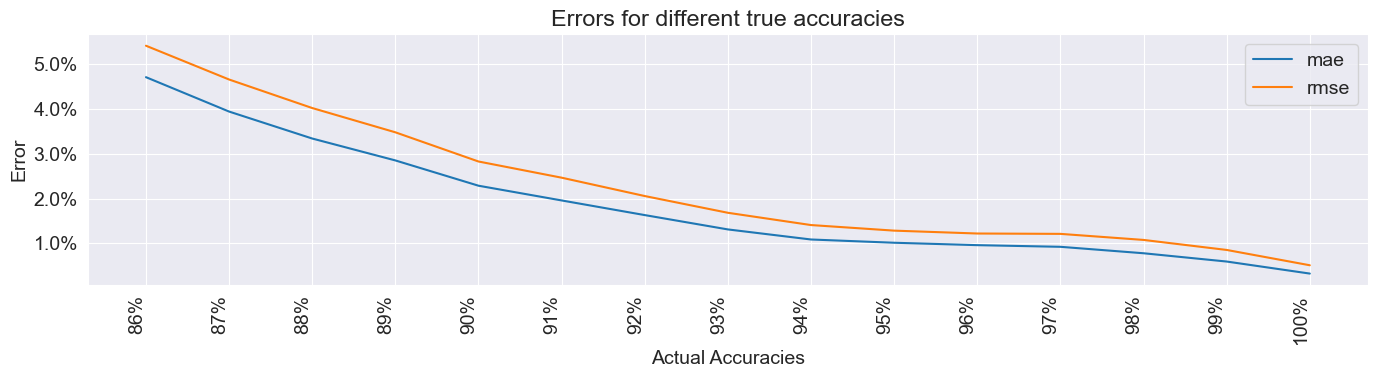

In [26]:
def get_error(y_preds, y_trues, a, b):
    y_preds = y_preds[(y_trues >= a) & (y_trues < b)]
    y_trues = y_trues[(y_trues >= a) & (y_trues < b)]

    return np.abs(y_preds - y_trues).mean(), ((y_preds - y_trues) ** 2).mean() ** 0.5


errors = []
bounds = np.linspace(0.7, 1, 31)
for a, b in zip(bounds[:-1], bounds[1:]):
    mae, rmse = get_error(y_preds, y_trues, a, b)
    errors.append([f"{b:.0%}", mae, rmse])

df_errors = pd.DataFrame(errors, columns=['bounds', 'mae', 'rmse'])
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_errors, x='bounds', y='mae', label='mae')
sns.lineplot(data=df_errors, x='bounds', y='rmse', label='rmse')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.title("Errors for different true accuracies")
plt.xlabel("Actual Accuracies")
plt.ylabel("Error")
_ = plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.savefig("error.png")

With domain expert input, it's logical.
There is significantly large deviations for lower accuracies, which is largely due to the undersampling of scores within that range. Refer to the diagram above to see the distribution of scores.

Fortunately, this isn't detrimental to common business use cases, as the scores of interest are those of higher accuracies.